# Assigning a 'walk' radius for possible PUDO points of a trip request


Assigning working directory 

In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

Local imports

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from ExMAS.utils import inData as inData

Retrieving config file, graph, and demand 

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 20
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


31-03-21 15:11:56-INFO-Initializing pairwise trip shareability between 20 and 20 trips.
31-03-21 15:11:56-INFO-creating combinations
31-03-21 15:11:56-INFO-380	 nR*(nR-1)
31-03-21 15:11:56-INFO-Reduction of feasible pairs by 99.47%
31-03-21 15:11:56-INFO-Degree 2 	Completed
31-03-21 15:11:56-INFO-trips to extend at degree 2 : 3
31-03-21 15:11:56-INFO-At degree 2 feasible extensions found out of 0 searched
31-03-21 15:11:56-INFO-Degree 3 	Completed
31-03-21 15:11:56-INFO-No more trips to exted at degree 3
31-03-21 15:11:57-INFO-Matching 20 trips to 23 rides in order to minimize u_veh
31-03-21 15:11:57-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,968 
reduced by matching to:                8,788
31-03-21 15:11:57-INFO-Calculations  completed
31-03-21 15:11:57-INFO-DotMap(VehHourTrav=8773, VehHourTrav_ns=8968, PassHourTrav=9124, PassHourTrav_ns=8968, PassUtility=137.2771, PassUtility_ns=139.1345, mean_lambda=0.15000000000000002, revenue_s=9416.4, revenue_ns=13

Specifying a walking radius

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

Function that searches for PUDO points that are 5 min walking from O/D of a request. The PUDO locations are stored within a Dataframe that can be easily retrieved later

In [6]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.requests)), columns = ['pax_id', 'origin', 'destination', \
                               'origin_nodes','destination_nodes','origin_dist','destination_dist'])
    pudo['pax_id'] = _inData.requests.index                                                                          #pax_id set as index
    pudo['origin'] = _inData.requests['origin'].tolist()                                                             #O/D of a pax_id is saved
    pudo['destination'] = _inData.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        origins = _inData.skim[pudo.iloc[i]['origin']][_inData.skim[pudo.iloc[i]['origin']]<walk_dist].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][_inData.skim[pudo.iloc[i]['destination']]<walk_dist].sort_values()
        pudo.at[i,'origin_nodes'] = list(origins.index)                                                              # a list of O/D pudo nodes saved for a pax_id
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        pudo.at[i,'origin_dist']  = origins.tolist()                                                                 # list of distances from pax_id to pudo, goes wtr origin_nodes and destination_nodes
        pudo.at[i,'destination_dist'] = destinations.tolist()
        
    _inData.pudo = pudo
    
    return _inData


In [7]:
inData = pudo_requests(inData)

PUDO points can be quickly visualised using the function below. 

In [12]:
def plot_pudo_demand(_inData, params, s=10):
    
    fig, ax = ox.plot_graph(_inData.G, figsize=(20, 20), node_size=0, edge_linewidth=0.5,
                            show=False, close=False,
                            edge_color='grey', bgcolor = 'white' )

    for _, r in _inData.pudo.iterrows():
        ax.scatter(_inData.G.nodes[r.origin]['x'], _inData.G.nodes[r.origin]['y'], c='green', s=s*2.5, marker='o')
        ax.scatter(_inData.G.nodes[r.destination]['x'], _inData.G.nodes[r.destination]['y'], c='red', s=s*2.5,marker='>')
        for node in r.origin_nodes:                                                                                         #quite inefficient code
            ax.scatter(_inData.G.nodes[node]['x'], _inData.G.nodes[node]['y'], c='blue', s=s*0.5, marker = 'X',alpha=0.4)
        for node in r.destination_nodes:  
            ax.scatter(_inData.G.nodes[node]['x'], _inData.G.nodes[node]['y'], c='orange', s=s*0.5, marker = 'X',alpha=0.4)
    plt.scatter(_inData.G.nodes[inData.stats['center']]['x'], _inData.G.nodes[_inData.stats['center']]['y'], c='black',
               s=10 * s, marker='+')
    plt.title(
        'Demand in {} with origins marked in green, destinations in orange'.format(params.city))
    plt.show()  

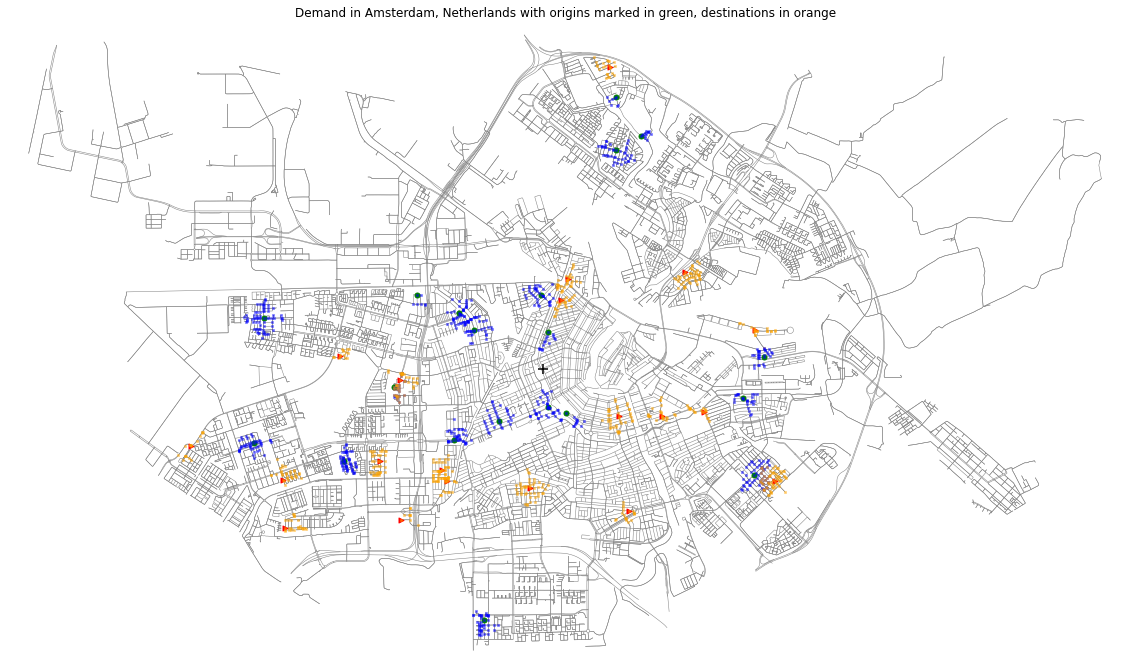

In [13]:
plot_pudo_demand(inData,params)